In [1]:
import import_ipynb
from ConsistencyIndexes import *
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

importing Jupyter notebook from ConsistencyIndexes.ipynb
importing Jupyter notebook from Functions.ipynb


### Get Original Frames

In [3]:
cap = open_vid("VDB/X.mp4")
org = get_frames(cap)
_,_,fps,_ = get_props(cap)

Width:  640
Height:  320
FPS:  24.0
Frame Count:  36


### Get Cartoonized Frames

In [4]:
cap = open_vid("Cartoonized/Xtoon.mp4")
car = get_frames(cap)
_,_,fps,_ = get_props(cap)

Width:  640
Height:  320
FPS:  24.0
Frame Count:  36


### Calculate 2D Kernel

In [83]:
def find_2Dkernel(input_images, target_images, kernel_size=3, epochs=1000, learning_rate=1e-3):
    # Normalize input and target images (to 0-1)
    input_images = [img / 255.0 for img in input_images]
    target_images = [img / 255.0 for img in target_images]
    # Convert input and target images to tensors
    input_images = torch.stack([torch.tensor(img, dtype=torch.float32) for img in input_images])
    target_images = torch.stack([torch.tensor(img, dtype=torch.float32) for img in target_images])   
    # Image Size
    height, width = input_images[0].shape[0], input_images[0].shape[1]    
    # Initialize the kernel
    kernel = torch.rand(1, 1, kernel_size, kernel_size, requires_grad=True)    
    # Use an optimizer to update the kernel
    optimizer = torch.optim.SGD([kernel], lr=learning_rate)    
    # List of loss over time
    L = []    
    # Iterate over epochs
    for epoch in range(epochs):
        total_loss = 0      
        # Iterate through each image and calculate the total loss
        for i in range(len(input_images)):
            optimizer.zero_grad()  # Clear the gradients from the previous iteration  
            # Separate each color channel
            r = input_images[i][:,:,0].view(1, 1, height, width)
            g = input_images[i][:,:,1].view(1, 1, height, width)
            b = input_images[i][:,:,2].view(1, 1, height, width)            
            # Apply convolution to each channel
            cr = F.conv2d(r, kernel, padding=1)
            cg = F.conv2d(g, kernel, padding=1)
            cb = F.conv2d(b, kernel, padding=1)            
            # Calculate the loss
            loss = (F.mse_loss(cr, target_images[i][:,:,0].unsqueeze(0).unsqueeze(0)) +
                    F.mse_loss(cg, target_images[i][:,:,1].unsqueeze(0).unsqueeze(0)) +
                    F.mse_loss(cb, target_images[i][:,:,2].unsqueeze(0).unsqueeze(0)))            
            # Add to total loss
            total_loss += loss.item()
            loss.backward()  # Compute gradients        
            optimizer.step()  # Update the kernel with the computed gradients        
        # Add total loss to list over epochs
        L.append(total_loss)        
        # Print loss every 10 iterations
        if epoch % 1 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Total Loss: {total_loss}", end='\r')    
    # Return the optimized kernel and list of loss over epochs
    return kernel.detach().numpy(), L

#### Train DNN and get Kernel 

In [142]:
k,l = find_2Dkernel(org,car,3,2000,1e-3)

#### Calculated Kernel

In [143]:
print(k)

[[[[-0.11707728  0.17420238  0.11876266]
   [ 0.08345454  0.4771772  -0.03955662]
   [ 0.12558264  0.1051952   0.01119323]]]]


#### Loss Over Epochs

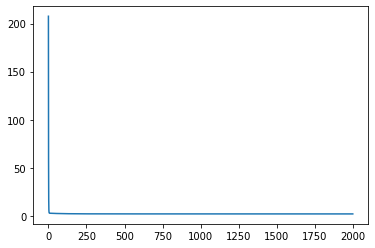

In [160]:
plt.plot(l)

### Apply Calculated Karnel to image

In [84]:
def apply_2dkernel(input_image, kernel):
    # Ensure input image is a float tensor and normalize it
    input_image = torch.tensor(input_image, dtype=torch.float32) / 255.0
    # Convert the kernel to a PyTorch tensor if it is not already
    if not isinstance(kernel, torch.Tensor):
        kernel = torch.tensor(kernel, dtype=torch.float32)
    # Get the dimensions of the input image
    height, width, channels = input_image.shape
    # Ensure size of image for convolution
    r = input_image[:,:,0].view(1, 1, height, width)
    g = input_image[:,:,1].view(1, 1, height, width)
    b = input_image[:,:,2].view(1, 1, height, width)
    # Apply the kernel to each channel
    cr = F.conv2d(r, kernel, padding=1)
    cg = F.conv2d(g, kernel, padding=1)
    cb = F.conv2d(b, kernel, padding=1)
    # Stack the channels back together
    output_image = torch.cat([cr, cg, cb], dim=1).squeeze(0).permute(1, 2, 0).detach().numpy()
    # Denormalize the output image (from 0-1 back to 0-255) and clip values to valid range
    output_image = (output_image * 255.0).clip(0, 255).astype('uint8')
    return output_image

### Apply Kernel to Video used in training

In [148]:
C = [apply_2dkernel(o,k) for o in org]

In [161]:
ThroughFrames(C)

#### Differences (Black is zero difference)

In [162]:
D = [np.abs(car[i]-apply_2dkernel(org[i],k)) for i in range(len(car))]

In [163]:
ThroughFrames(D)

### Kernel Applied to other video

In [152]:
org1 = get_frames(open_vid("VDB/Y.mp4"))
car1 = get_frames(open_vid("Cartoonized/Ytoon.mp4"))
C1 = [apply_2dkernel(o,k) for o in org1]
D1 = [np.abs(car1[i]-apply_2dkernel(org1[i],k)) for i in range(len(car1))]
c1 = [cv2.filter2D(o, ddepth=-1, kernel=np.asarray(k[0][0])) for o in org1]

In [164]:
ThroughFrames(c1)

In [165]:
ThroughFrames(C1)

In [166]:
ThroughFrames(D1)

### DNN for 3D Kernel

In [85]:
def find_3Dkernel(input_images, target_images, kernel_size=3, epochs=1000, learning_rate=1e-3):
    # Normalize input and target images (to 0-1)
    input_images = [img / 255.0 for img in input_images]
    target_images = [img / 255.0 for img in target_images]
    # Convert input and target images to tensors
    input_images = torch.stack([torch.tensor(img, dtype=torch.float32) for img in input_images])
    target_images = torch.stack([torch.tensor(img, dtype=torch.float32) for img in target_images])   
    # Image Size
    height, width = input_images[0].shape[0], input_images[0].shape[1]    
    # Initialize the kernel
    kernelr = torch.rand(1, 1, kernel_size, kernel_size, requires_grad=True)  
    kernelg = torch.rand(1, 1, kernel_size, kernel_size, requires_grad=True)  
    kernelb = torch.rand(1, 1, kernel_size, kernel_size, requires_grad=True)  
    # Use an optimizer to update the kernel
    optimizer = torch.optim.SGD([kernelr,kernelg,kernelb], lr=learning_rate)    
    # List of loss over time
    L = []    
    # Iterate over epochs
    for epoch in range(epochs):
        total_loss = 0      
        # Iterate through each image and calculate the total loss
        for i in range(len(input_images)):
            optimizer.zero_grad()  # Clear the gradients from the previous iteration  
            # Separate each color channel
            r = input_images[i][:,:,0].view(1, 1, height, width)
            g = input_images[i][:,:,1].view(1, 1, height, width)
            b = input_images[i][:,:,2].view(1, 1, height, width)            
            # Apply convolution to each channel
            cr = F.conv2d(r, kernelr, padding=1)
            cg = F.conv2d(g, kernelg, padding=1)
            cb = F.conv2d(b, kernelb, padding=1)            
            # Calculate the loss
            loss = (F.mse_loss(cr, target_images[i][:,:,0].unsqueeze(0).unsqueeze(0)) +
                    F.mse_loss(cg, target_images[i][:,:,1].unsqueeze(0).unsqueeze(0)) +
                    F.mse_loss(cb, target_images[i][:,:,2].unsqueeze(0).unsqueeze(0)))            
            # Add to total loss
            total_loss += loss.item()
            loss.backward()  # Compute gradients        
            optimizer.step()  # Update the kernel with the computed gradients        
        # Add total loss to list over epochs
        L.append(total_loss)        
        # Print loss every 10 iterations
        if epoch % 1 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Total Loss: {total_loss}", end='\r')    
    # Return the optimized kernel and list of loss over epochs
    return [kernelr.detach().numpy(),kernelg.detach().numpy(),kernelb.detach().numpy()], L

### Train DNN for 3D Kernel

In [167]:
k3d,l3d = find_3Dkernel(org,car,3,100,1e-3)

### Calculated Kernels

In [168]:
print(k3d[0])
print(k3d[1])
print(k3d[2])

[[[[-0.12880068 -0.31311655  0.148783  ]
   [ 0.4606632   0.4521125   0.3544668 ]
   [ 0.01233711  0.35646823 -0.39860234]]]]
[[[[ 0.22344309  0.26510024  0.23608764]
   [-0.07694138  0.46053693 -0.05531402]
   [-0.18870662 -0.15387362  0.2372263 ]]]]
[[[[-0.02202662  0.5744075  -0.10779057]
   [-0.11189078  0.3386241  -0.09678408]
   [-0.08710568  0.5889042  -0.15465868]]]]


### Loss Over Epochs

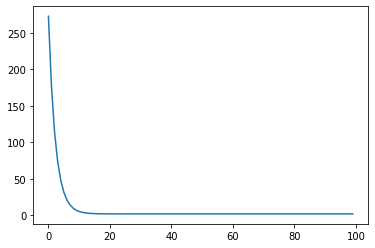

In [169]:
plt.plot(l3d)

### Apply 3D Kernel

In [86]:
def apply_3dkernel(input_image, kernel):
    # Ensure input image is a float tensor and normalize it
    input_image = torch.tensor(input_image, dtype=torch.float32) / 255.0
    # Convert the kernel to a PyTorch tensor if it is not already
    if not isinstance(kernel, torch.Tensor):
        kernel = torch.tensor(kernel, dtype=torch.float32)
    # Get the dimensions of the input image
    height, width, channels = input_image.shape
    # Ensure size of image for convolution
    r = input_image[:,:,0].view(1, 1, height, width)
    g = input_image[:,:,1].view(1, 1, height, width)
    b = input_image[:,:,2].view(1, 1, height, width)
    # Apply the kernel to each channel
    cr = F.conv2d(r, kernel[0], padding=1)
    cg = F.conv2d(g, kernel[1], padding=1)
    cb = F.conv2d(b, kernel[2], padding=1)
    # Stack the channels back together
    output_image = torch.cat([cr, cg, cb], dim=1).squeeze(0).permute(1, 2, 0).detach().numpy()
    # Denormalize the output image (from 0-1 back to 0-255) and clip values to valid range
    output_image = (output_image * 255.0).clip(0, 255).astype('uint8')
    return output_image

### 3D Kernel applied to original video

In [172]:
C3d = [apply_3dkernel(o,k3d) for o in org]
ThroughFrames(C3d)

### Difference with target

In [173]:
D3d = [np.abs(car[i]-apply_3dkernel(org[i],k3d)) for i in range(len(car))]
ThroughFrames(D3d)

### Using another video

In [183]:
org13d = get_frames(open_vid("VDB/puppies.mp4"))
car13d = get_frames(open_vid("Cartoonized/puppiestoon.mp4"))
C13d = [apply_3dkernel(o,k3d) for o in org13d]
D13d = [np.abs(car13d[i]-apply_3dkernel(org13d[i],k3d)) for i in range(len(car13d))]

In [181]:
ThroughFrames(C13d)

In [184]:
ThroughFrames(D13d)

### Calculate Kernel for Edge Detection

In [80]:
cap = open_vid("VDB/X.mp4")
orgE = get_frames(cap)
get_props(cap);

Width:  640
Height:  320
FPS:  24.0
Frame Count:  36


In [82]:
ed = [canny_edge(o) for o in orgE[:50]]
ThroughFrames(ed)

In [125]:
def find_2DkernelC(input_images, target_images, kernel=None, kernel_size=3, epochs=1000, lr=1e-3):
    # Normalize input and target images (to 0-1)
    input_images = [img / 255.0 for img in input_images]
    target_images = [img / 255.0 for img in target_images]
    
    # Convert input and target images to tensors
    input_images = torch.stack([torch.tensor(img, dtype=torch.float32) for img in input_images])
    target_images = torch.stack([torch.tensor(img, dtype=torch.float32) for img in target_images])   
    
    # Image Size
    height, width = input_images[0].shape[0], input_images[0].shape[1]    
    
    # Initialize the kernel
    if kernel is None:
        kernel = torch.rand(1, 1, kernel_size, kernel_size, requires_grad=True)
    else:
        kernel = torch.tensor(kernel, dtype=torch.float32).view(1,1,kernel.shape[0],kernel.shape[1])  # Ensure it's a tensor
        kernel.requires_grad_(True)  # Set requires_grad=True for the leaf tensor
        
    # Use an optimizer to update the kernel
    optimizer = torch.optim.SGD([kernel], lr=lr)    
    
    # List of loss over time
    L = []    
    
    padding = kernel[0][0].shape[0]//2
    
    # Iterate over epochs
    for epoch in range(epochs):
        total_loss = 0      
        # Iterate through each image and calculate the total loss
        for i in range(len(input_images)):
            optimizer.zero_grad()  # Clear the gradients from the previous iteration 
            
            # Separate each color channel
            r = input_images[i][:,:,0].view(1, 1, height, width)
            g = input_images[i][:,:,1].view(1, 1, height, width)
            b = input_images[i][:,:,2].view(1, 1, height, width)            
            
            # Apply convolution to each channel
            cr = F.conv2d(r, kernel, padding=padding)
            cg = F.conv2d(g, kernel, padding=padding)
            cb = F.conv2d(b, kernel, padding=padding)            
            
            # Calculate the loss
            loss = (F.mse_loss(cr, target_images[i][:,:,0].unsqueeze(0).unsqueeze(0)) +
                    F.mse_loss(cg, target_images[i][:,:,1].unsqueeze(0).unsqueeze(0)) +
                    F.mse_loss(cb, target_images[i][:,:,2].unsqueeze(0).unsqueeze(0)))            
            
            # Add to total loss
            total_loss += loss.item()
            loss.backward()  # Compute gradients        
            optimizer.step()  # Update the kernel with the computed gradients        
        
        # Add total loss to list over epochs
        L.append(total_loss)        
        
        # Print loss every epoch
        if epoch % 1 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Total Loss: {total_loss}", end='\r')    
    
    # Return the optimized kernel and list of loss over epochs
    return kernel.detach().numpy(), L

In [134]:
ked,led = find_2DkernelC(orgE,orgE,epochs=2,lr=1e-3)

In [135]:
print(ked)

[[[[ 0.34859854 -0.05776078  0.27837604  0.04321105 -0.40997612]
   [ 0.333263    0.5017552   0.3312931   0.48203894 -0.3639986 ]
   [-0.3033903   0.25969505 -0.40633988 -0.20842764  0.1559517 ]
   [ 0.04213686 -0.3442806  -0.05506739  0.50000596 -0.33135495]
   [ 0.41912013 -0.10673925 -0.45176157  0.36731735  0.28507236]]]]


In [ ]:
# Now for each step in the process:
# -edges
# -cluster